# JMA Radar-AMeDAS analysis 

# 仕様

http://www.data.jma.go.jp/add/suishin/jyouhou/pdf/162.pdf

<img src="1621.png" width="70%">
<img src="1622.png" width="70%">

[GRIB2 templates for JMA Radar-AMeDAS analysis
data](https://05377833970023498008.googlegroups.com/attach/fa546c02ad4456be/GRIB2templatesforJMARadar-AMeDASanalysisdataPDT4.50008andGDT5.200.pdf?part=0.1&vt=ANaJVrEQw1zK229zXmYHNvXgtuwxdUXwyXHfAi1tCWTZxEzmiIHM1LlYLHlF2ZvHzHB-PDrdSNT48-UFEHAbfZ286Iz5AgZFNLrwhheJoSmSSj5RKyKUN3Q)

# ref. The Python-ARM Radar Toolkit

https://github.com/ARM-DOE/pyart

```python
def _decode_rle8(compr_data, key, decompr_size):
    """ Decode 8-bit MDV run length encoding. """
    # Encoding is described in section 7 of:
    # http://rap.ucar.edu/projects/IHL/RalHtml/protocols/mdv_file/
    # This function would benefit greate by being rewritten in Cython
    data = np.fromstring(compr_data, dtype='>B')
    out = np.empty((decompr_size, ), dtype='uint8')
    data_ptr = 0
    out_ptr = 0
    while data_ptr != len(data):
        v = data[data_ptr]
        if v != key:  # not encoded
            out[out_ptr] = v
            data_ptr += 1
            out_ptr += 1
        else:   # run length encoded
            count = data[data_ptr+1]
            value = data[data_ptr+2]
            out[out_ptr:out_ptr+count] = value
            data_ptr += 3
            out_ptr += count
    return out.tostring()
```
https://github.com/ARM-DOE/pyart/blob/62d9d9210d3e09a8f060b28b66da380ec09c1bc0/pyart/io/mdv_common.py#L1144


## NumPy fromstring

http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.fromstring.html

ndarray.reshape() で配列形状の変更

# Get data file

In [68]:
! wget http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/jma-radar/synthetic/original/2016/03/06/Z__C_RJTD_20160306190000_RDR_JMAGPV__grib2.tar

--2016-03-06 19:42:24--  http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/jma-radar/synthetic/original/2016/03/06/Z__C_RJTD_20160306190000_RDR_JMAGPV__grib2.tar
Resolving database.rish.kyoto-u.ac.jp (database.rish.kyoto-u.ac.jp)... 133.3.8.137
Connecting to database.rish.kyoto-u.ac.jp (database.rish.kyoto-u.ac.jp)|133.3.8.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286720 (280K) [application/x-tar]
Saving to: ‘Z__C_RJTD_20160306190000_RDR_JMAGPV__grib2.tar.1’

100%[======================================>] 286,720     32.9KB/s   in 8.5s   

2016-03-06 19:42:38 (32.9 KB/s) - ‘Z__C_RJTD_20160306190000_RDR_JMAGPV__grib2.tar.1’ saved [286720/286720]



In [69]:
! tar xf Z__C_RJTD_20160306190000_RDR_JMAGPV__grib2.tar

# Parse binary file

In [71]:
%matplotlib inline 
import numpy as np
from io import BytesIO
import struct
import datetime

import matplotlib.pyplot as plt

file = 'Z__C_RJTD_20160306190000_RDR_JMAGPV_Ggis1km_Prr10lv_ANAL_grib2.bin'

fileptr = open(file, 'rb')

fileptr.seek(16 + 21 + 72 + 7)
print struct.unpack('>H', fileptr.read(2)) # product template number

fileptr.seek(16 + 21 + 72 + 82)
print struct.unpack('>I', fileptr.read(4))
fileptr.seek(16 + 21 + 72 +  82 + 12)
maxv = struct.unpack('>H', fileptr.read(2))[0]

fileptr.seek(16 + 21 + 72 +  82 + 17)

level_values = [-0.] #no data
for nn in range(0, 251):
    level_values.append(struct.unpack('>H', fileptr.read(2))[0] / 100.)
    
fileptr.seek(16 + 21 + 72 +  82 + 519 + 6)
sec7_length = struct.unpack('>I', fileptr.read(4))[0]
print sec7_length
print struct.unpack('>B', fileptr.read(1))
data = fileptr.read(sec7_length - 5)
compr_data = np.fromstring(data, dtype='>B')

(50008,)
(519,)
256350
(7,)


In [117]:
def parse_pdt_4_50008(fileptr):
    format = '>5B H 2B I 2B I 2B I H 6B H 3B H B H 8s 8s 8s'
    d = struct.unpack(
        format,
        fileptr.read(struct.calcsize(format)))
    return {
        'parameter_category': d[0],
        'parameter_number': d[1],
        'year': d[15],
        'month': d[16],
        'day': d[17],
        'hour': d[18],
        'minute': d[19],
        'second': d[20]
    }

In [118]:
fileptr.seek(16 + 21 + 72 + 7)
print struct.unpack('>H', fileptr.read(2))
parse_pdt_4_50008(fileptr)

(50008,)


{'day': 6,
 'hour': 19,
 'minute': 0,
 'month': 3,
 'parameter_category': 1,
 'parameter_number': 201,
 'second': 0,
 'year': 2016}

In [132]:
def parse_drt_5_200(fileptr):
    format = '>B 2H B 251H'
    d = struct.unpack(
        format,
        fileptr.read(struct.calcsize(format)))
    drt = {
        'nbit': d[0],
        'max_value': d[1],
        'max_value_level': d[2],
        'decimal_scale_factor': d[3],
        'level_values': [-0.] # no data
    }
    scale_factor = pow(10., d[3])
    for v in d[4:]:
        drt['level_values'].append(v / scale_factor)
    return drt

In [133]:
fileptr.seek(16 + 21 + 72 +  82 + 9)
print struct.unpack('>H', fileptr.read(2)) 
parse_drt_5_200(fileptr)

(200,)


{'decimal_scale_factor': 2,
 'level_values': [-0.0,
  0.0,
  0.1,
  0.25,
  0.35,
  0.45,
  0.55,
  0.65,
  0.75,
  0.85,
  0.95,
  1.05,
  1.15,
  1.25,
  1.35,
  1.45,
  1.55,
  1.65,
  1.75,
  1.85,
  1.95,
  2.13,
  2.38,
  2.63,
  2.88,
  3.13,
  3.38,
  3.63,
  3.88,
  4.13,
  4.38,
  4.63,
  4.88,
  5.25,
  5.75,
  6.25,
  6.75,
  7.25,
  7.75,
  8.25,
  8.75,
  9.25,
  9.75,
  10.5,
  11.5,
  12.5,
  13.5,
  14.5,
  15.5,
  16.5,
  17.5,
  18.5,
  19.5,
  20.5,
  21.5,
  22.5,
  23.5,
  24.5,
  25.5,
  26.5,
  27.5,
  28.5,
  29.5,
  30.5,
  31.5,
  32.5,
  33.5,
  34.5,
  35.5,
  36.5,
  37.5,
  38.5,
  39.5,
  40.5,
  41.5,
  42.5,
  43.5,
  44.5,
  45.5,
  46.5,
  47.5,
  48.5,
  49.5,
  50.5,
  51.5,
  52.5,
  53.5,
  54.5,
  55.5,
  56.5,
  57.5,
  58.5,
  59.5,
  60.5,
  61.5,
  62.5,
  63.5,
  64.5,
  65.5,
  66.5,
  67.5,
  68.5,
  69.5,
  70.5,
  71.5,
  72.5,
  73.5,
  74.5,
  75.5,
  76.5,
  77.5,
  78.5,
  79.5,
  80.5,
  81.5,
  82.5,
  83.5,
  84.5,
  85.5,
  86.5

<img src="1623.png" width="70%">

In [44]:
def decode_rle_levelvalues(compr_data, ndata, nbit, maxv, level_values):
    out = np.empty(ndata, dtype='float16')
    lngu = pow(2, nbit) - 1 - maxv
    pv = -1
    k = 0
    count = 1
    n = 0
    for v in np.nditer(compr_data):
        if v <= maxv:
            if pv >= 0:
                out[k: k + count] = pv
                k += count
            count = 1
            n = 0
            pv = level_values[v]
        else:
            count += pow(lngu, n) * (v - maxv - 1)
            n += 1
    out[k: k + count] = pv
    return out

In [72]:
data2 = decode_rle_levelvalues(compr_data, 2560*3360, 8, maxv, level_values)
data = np.reshape(data2, (3360, 2560))
data

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float16)

In [62]:
data.size

8601600

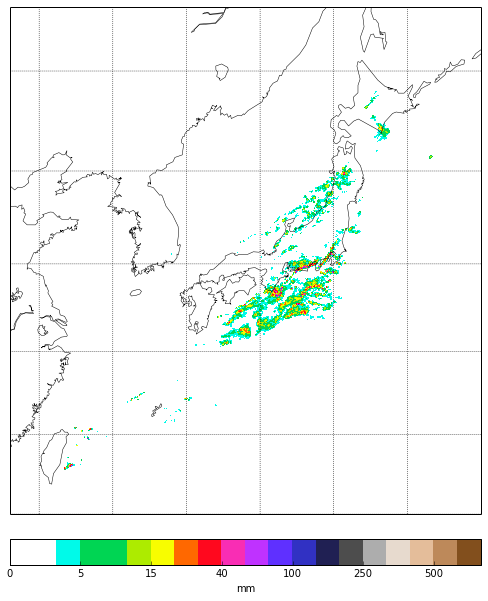

In [95]:
%matplotlib inline 
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
m = Basemap(projection='merc',llcrnrlat=20.,urcrnrlat=48., llcrnrlon=118.,urcrnrlon=150.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(0,60,5), linewidth=0.5)
m.drawmeridians(np.arange(100,170,5), linewidth=0.5)

lons, lats = np.meshgrid(np.linspace(118, 150, 2560), np.linspace(48,20,3360))
x, y = m(lons, lats) 
clevs = [0,1,2.5,5,7.5,10,15,20,30,40,50,70,100,150,200,250,300,400,500,600,750]
cs = m.contourf(x,y,data,clevs,cmap=cm.s3pcpn)
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('mm')

plt.show()

<img src="201603070400-00.png">